![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [6]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [9]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [11]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [13]:
# Análisis descriptivo detallado para la variable "season"
season_stats = bikes.groupby('season')['total'].agg(['mean', 'std', 'min', 'max', 'median', 'count', 
                                                     lambda x: np.percentile(x, 25), 
                                                     lambda x: np.percentile(x, 75)])
season_stats.rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'}, inplace=True)

print("Estadísticas descriptivas por temporada (season):")
print(season_stats)

# Análisis descriptivo detallado para la variable "hour"
hour_stats = bikes.groupby('hour')['total'].agg(['mean', 'std', 'min', 'max', 'median', 'count', 
                                                 lambda x: np.percentile(x, 25), 
                                                 lambda x: np.percentile(x, 75)])
hour_stats.rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'}, inplace=True)

print("\nEstadísticas descriptivas por hora del día (hour):")
print(hour_stats)


Estadísticas descriptivas por temporada (season):
              mean         std  min  max  median  count   25%    75%
season                                                              
1       116.343261  125.273974    1  801    78.0   2686  24.0  164.0
2       215.251372  192.007843    1  873   172.0   2733  49.0  321.0
3       234.417124  197.151001    1  977   195.0   2733  68.0  347.0
4       198.988296  177.622409    1  948   161.0   2734  51.0  294.0

Estadísticas descriptivas por hora del día (hour):
            mean         std  min  max  median  count     25%     75%
hour                                                                 
0      55.138462   43.620012    2  283    41.0    455   24.00   74.50
1      33.859031   34.112105    1  168    19.0    454   11.00   46.00
2      22.899554   26.110267    1  119    11.0    448    5.00   32.00
3      11.757506   12.666442    1   66     6.0    433    3.00   15.00
4       6.407240    4.217633    1   28     6.0    442    3.00   

##  Análisis descriptivo e inferencias

### Análisis por temporada (season):

| Season        | Promedio | Desviación Estándar | Mínimo | 25%  | Mediana | 75%  | Máximo | Observaciones |
|---------------|----------|---------------------|--------|------|---------|------|--------|---------------|
| 1 (Invierno)  | 116.34   | 125.27              | 1      | 24.0 | 78.0    | 164.0| 801    | 2686          |
| 2 (Primavera) | 215.25   | 192.01              | 1      | 49.0 | 172.0   | 321.0| 873    | 2733          |
| 3 (Verano)    | 234.42   | 197.15              | 1      | 68.0 | 195.0   | 347.0| 977    | 2733          |
| 4 (Otoño)     | 198.99   | 177.62              | 1      | 51.0 | 161.0   | 294.0| 948    | 2734          |

#### Interpretación de (season):

- El mayor promedio de alquileres se presenta en verano (temporada 3), posteriomente por primavera (temporada 2). Esto muestra que las estaciones cálidas favorecen el uso de bicicletas.
- El invierno (temporada 1) muestra el promedio más bajo, probablemente debido a condiciones climáticas menos favorables para los usuarios.
- La variabilidad es alta en todas las temporadas, reflejada en la desviación estándar, lo que evidencia que el número de alquileres cambia  dentro de cada estación.
- La mediana es más baja que el promedio en todas las temporadas, lo que sugiere días u horas específicos con picos puntuales en la demanda.

---

### Análisis por hora del día (hour):

| Hora           | Promedio | Desviación Estándar | Mínimo | 25%    | Mediana | 75%    | Máximo | Observaciones |
|----------------|----------|---------------------|--------|--------|---------|--------|--------|---------------|
| 0 (Medianoche) | 55.14    | 43.62               | 2      | 24.00  | 41.0    | 74.50  | 283    | 455           |
| 1              | 33.86    | 34.11               | 1      | 11.00  | 19.0    | 46.00  | 168    | 454           |
| 2              | 22.90    | 26.11               | 1      | 5.00   | 11.0    | 32.00  | 119    | 448           |
| 3              | 11.76    | 12.67               | 1      | 3.00   | 6.0     | 15.00  | 66     | 433           |
| 4              | 6.41     | 4.22                | 1      | 3.00   | 6.0     | 9.00   | 28     | 442           |
| 5              | 19.77    | 12.78               | 1      | 8.00   | 19.0    | 29.00  | 57     | 452           |
| 6              | 76.26    | 54.75               | 1      | 24.50  | 75.0    | 118.00 | 213    | 455           |
| 7              | 213.12   | 159.21              | 1      | 63.00  | 208.0   | 334.00 | 596    | 455           |
| 8              | 362.77   | 231.72              | 8      | 133.50 | 392.0   | 563.50 | 839    | 455           |
| 9              | 221.78   | 92.10               | 14     | 161.00 | 217.0   | 294.50 | 414    | 455           |
| 10             | 175.09   | 101.81              | 17     | 106.00 | 149.0   | 218.50 | 539    | 455           |
| 11             | 210.67   | 127.44              | 10     | 123.00 | 183.0   | 265.50 | 647    | 455           |
| 12             | 256.51   | 143.88              | 3      | 157.00 | 234.5   | 332.00 | 757    | 456           |
| 13             | 257.79   | 149.17              | 11     | 154.00 | 226.5   | 329.00 | 729    | 456           |
| 14             | 243.44   | 147.56              | 12     | 144.00 | 212.0   | 311.25 | 730    | 456           |
| 15             | 254.30   | 144.24              | 7      | 154.00 | 232.0   | 331.00 | 724    | 456           |
| 16             | 316.37   | 145.66              | 11     | 211.75 | 309.5   | 421.00 | 783    | 456           |
| 17             | 468.77   | 223.78              | 15     | 277.00 | 480.5   | 608.50 | 970    | 456           |
| 18             | 430.86   | 219.91              | 23     | 240.75 | 422.5   | 564.00 | 977    | 456           |
| 19             | 315.28   | 156.64              | 11     | 190.00 | 312.5   | 416.00 | 743    | 456           |
| 20             | 228.52   | 116.41              | 11     | 136.75 | 224.0   | 302.00 | 551    | 456           |
| 21             | 173.37   | 87.63               | 6      | 103.50 | 171.5   | 230.00 | 584    | 456           |
| 22             | 133.58   | 69.84               | 9      | 80.00  | 129.0   | 175.00 | 502    | 456           |
| 23             | 89.51    | 51.64               | 4      | 52.75  | 80.0    | 123.00 | 256    | 456           |

####  Interpretación de (hour):

- Las horas pico (17:00-18:00) presentan los mayores promedios en alquiler de bicicletas, lo que coincide con horarios típicos de regreso del trabajo o estudio.
- Se observa también un aumento significativo en la demanda alrededor de las 8:00, indicando desplazamientos frecuentes durante la mañana hacia lugares laborales o educativos.
- Entre la 1:00 y las 5:00, la demanda cae considerablemente, alcanzando su punto más bajo a las 4:00.
- La alta desviación estándar observada en horas pico (especialmente 8:00, 17:00 y 18:00) indica mucha variabilidad, posiblemente debida a factores externos como días laborables versus fines de semana o condiciones climáticas específicas.

---

### Conclusiones generales:

- La demanda de bicicletas está claramente relacionada con factores climáticos y hábitos diarios de movilidad.
- Existen periodos específicos, como horas pico diarias y temporadas cálidas, en los cuales la demanda aumenta considerablemente. Esto podría ser aprovechado por servicios de bicicletas compartidas para planificar mejor la distribución y disponibilidad del servicio.
- La variabilidad identificada indica que incluir variables relacionadas con temporada y hora en modelos predictivos (por ejemplo, árboles de decisión) mejoraría significativamente la precisión de dichos modelos.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

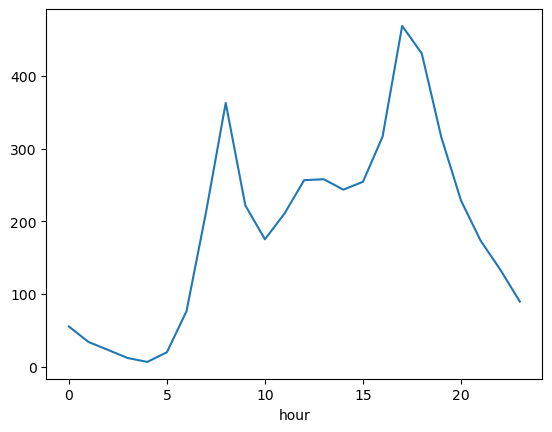

In [21]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

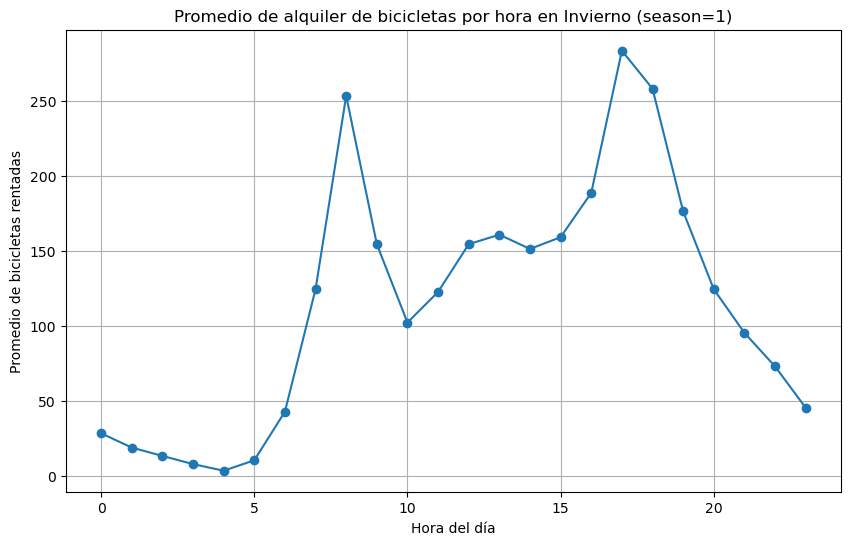

In [33]:
import matplotlib.pyplot as plt  

# Generar gráfica
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot(
    figsize=(10,6), marker='o', 
    title='Promedio de alquiler de bicicletas por hora en Invierno (season=1)'
)
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas rentadas')
plt.grid(True)

# Guardar gráfica como imagen
plt.savefig('bicicletas_invierno.png', dpi=300)

# Mostrar gráfica
plt.show()

### Promedio de alquiler de bicicletas por hora (Invierno - Season 1):

Al observar la gráfica sobre el uso promedio de bicicletas por hora durante el invierno, se identifican claramente dos momentos del día con alta demanda. El primero ocurre alrededor de las 8 de la mañana, alcanzando un pico significativo, probablemente debido a desplazamientos hacia lugares de trabajo o estudio. El segundo pico ocurre entre las 17:00 y 18:00 horas, coincidiendo con el regreso de las personas a sus hogares.

Durante la madrugada (aproximadamente entre las 0:00 y 5:00 horas), la demanda es muy baja, prácticamente nula alrededor de las 4:00. Este comportamiento refleja claramente los hábitos diarios de las personas, influenciados adicionalmente por las condiciones del clima en invierno, lo que reduce la demanda en las horas menos cómodas para el uso de bicicletas.

La gráfica también muestra cierta irregularidad entre las 9:00 y 16:00 horas, con variaciones moderadas que sugieren que, aunque la demanda es menor que en las horas pico, existe un uso constante durante todo el día. Esto puede indicar desplazamientos ocasionales o recreativos durante las horas de luz en invierno.

En conclusión, para mejorar el servicio en invierno, sería importante asegurar la disponibilidad de bicicletas especialmente en las horas de alta demanda (mañana y tarde), mientras que en la madrugada la necesidad de bicicletas es mucho menor.


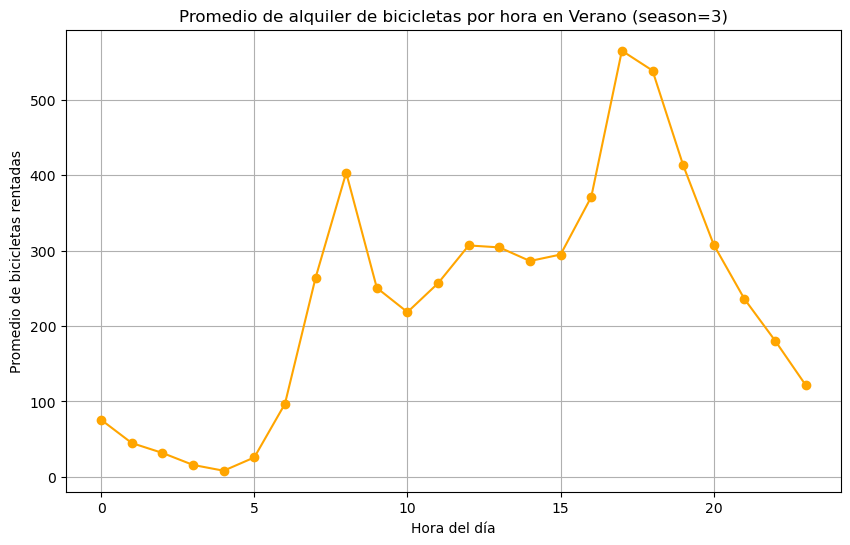

In [35]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# Generar gráfica
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot(
    figsize=(10,6), marker='o', color='orange', 
    title='Promedio de alquiler de bicicletas por hora en Verano (season=3)'
)
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas rentadas')
plt.grid(True)

# Guardar gráfica como imagen
plt.savefig('bicicletas_verano.png', dpi=300)

# Mostrar gráfica
plt.show()


### Promedio de alquiler de bicicletas por hora (Verano - Season 3):

En la gráfica del uso promedio de bicicletas durante el verano se observan claramente patrones similares a los del invierno, aunque con una demanda notablemente mayor. Existen dos momentos del día con una demanda especialmente alta: alrededor de las 8:00 horas y un segundo pico más pronunciado entre las 17:00 y las 18:00 horas, coincidiendo con horarios típicos de desplazamientos laborales o académicos.

Comparado con el invierno, durante el verano hay una demanda considerablemente mayor durante todo el día, incluso en horas intermedias (entre 9:00 y 16:00 horas). Este incremento en la demanda se puede ver explicado por el clima más cálido y condiciones favorables para el uso de bicicletas durante toda la jornada.

En horas de la madrugada (0:00 - 5:00), la demanda sigue siendo baja, pero ligeramente superior al invierno, indicando que aún en verano hay poca actividad en estas horas, aunque es menos extrema la caída respecto al invierno.

En conclusión, durante el verano es importante que los servicios de bicicletas se preparen con mayor capacidad, especialmente en horas pico, además de considerar una mayor disponibilidad general durante todo el día debido al aumento sostenido de la demanda.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a un conjunto de train de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [39]:
# Celda 3
# Importar librerías necesarias
from sklearn.linear_model import LinearRegression
import pandas as pd

# Crear variables dummy para 'season', dado que es categórica
bikes_dummies = pd.get_dummies(bikes, columns=['season'], drop_first=True)

# Definir las variables predictoras (dummies de 'season' y 'hour') y la variable respuesta ('total')
X = bikes_dummies[['hour', 'season_2', 'season_3', 'season_4']]
y = bikes_dummies['total']

# Ajustar el modelo de regresión lineal
model_linreg = LinearRegression()
model_linreg.fit(X, y)

# Imprimir los coeficientes del modelo
coeficientes = pd.DataFrame({
    'Variable': ['hour', 'season_2 (Primavera)', 'season_3 (Verano)', 'season_4 (Otoño)'],
    'Coeficiente': model_linreg.coef_
})

intercepto = model_linreg.intercept_

print('Intercepto:', intercepto)
print('\nCoeficientes del modelo de regresión lineal:')
print(coeficientes)


Intercepto: -6.430262462305961

Coeficientes del modelo de regresión lineal:
               Variable  Coeficiente
0                  hour    10.545206
1  season_2 (Primavera)   100.317232
2     season_3 (Verano)   119.467550
3      season_4 (Otoño)    84.083118


## Análisis de regresión lineal

**Intercepto:**  
El intercepto es -6.43, lo que sugiere que, en promedio, cuando la hora es 0 (medianoche) y la temporada es invierno (temporada base), el modelo estima un valor negativo de alquiler de bicicletas, algo que claramente no es realista. Esto indica una posible limitación del modelo lineal para explicar adecuadamente el comportamiento en estos extremos.

**Coeficientes:**

- Hora (hour): El coeficiente de 10.55 indica que, en promedio, cada incremento de una hora en el día está asociado con un aumento aproximado de 11 bicicletas alquiladas. Esto podría reflejar la tendencia general creciente desde la madrugada hasta las horas pico del día.
  
- Primavera (season_2): El coeficiente positivo (100.32) muestra que en primavera el alquiler promedio aumenta considerablemente en comparación con invierno.
  
- Verano (season_3): Con un coeficiente aún mayor (119.47), indica que el verano es la temporada con mayor impacto positivo en la demanda, siendo aproximadamente 119 bicicletas más en promedio comparado con el invierno.
  
- Otoño (season_4): El coeficiente (84.08) indica que también en otoño el alquiler es más alto en comparación con invierno, pero en menor medida que primavera y verano.

### Limitaciones del modelo lineal en este contexto:

- Relación lineal: El modelo lineal asume una relación constante y proporcional entre las variables predictoras y la variable respuesta, lo que podría no reflejar adecuadamente patrones complejos (como picos específicos o comportamientos no lineales).
  
- Predicciones negativas: El modelo puede predecir valores negativos para ciertos escenarios (como ocurre con el intercepto), algo que no tiene sentido práctico en este contexto.
  
- No se consideran interacciones: El modelo actual no incluye interacciones entre variables, como por ejemplo entre la hora del día y la temporada, que podrían mejorar considerablemente la precisión del modelo.

Dadas estas limitaciones, sería interesante considerar modelos más flexibles (por ejemplo, árboles de decisión) para explicar mejor la dinámica de alquiler de bicicletas.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

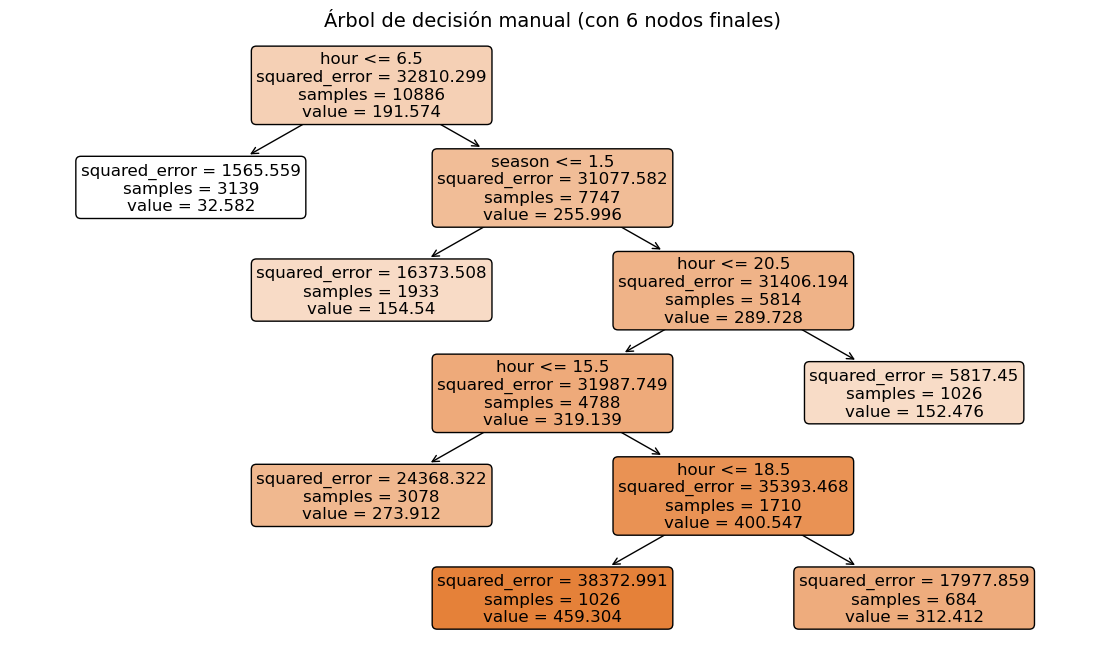

In [47]:
# Celda 4
# Importar librerías necesarias
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Definir variables predictoras y variable respuesta
X_tree = bikes[['hour', 'season']]
y_tree = bikes['total']

# Ajustar árbol de decisión especificando manualmente parámetros
# Controlamos el árbol con una profundidad que garantice al menos 6 nodos finales (hojas)
arbol_manual = DecisionTreeRegressor(max_leaf_nodes=6, random_state=42)
arbol_manual.fit(X_tree, y_tree)

# Graficar el árbol generado
plt.figure(figsize=(14,8))
plot_tree(arbol_manual, feature_names=['hour', 'season'], filled=True, rounded=True, fontsize=12)
plt.title('Árbol de decisión manual (con 6 nodos finales)', fontsize=14)
plt.show()


## Análisis del Árbol de Decisión (manual)

Del árbol de decisión generado manualmente, podemos obtener las siguientes conclusiones importantes:

- El árbol primero divide los datos por la hora del día (hour). Claramente se identifica que antes de las 6:30 aproximadamente, la demanda de bicicletas es bastante baja, con un promedio cercano a 33 bicicletas por hora.

- Después de esta hora, la siguiente división ocurre según la temporada (season). Las temporadas más cálidas (primavera y verano) presentan una demanda significativamente más alta, con un promedio cercano a 256 bicicletas por hora. En cambio, las temporadas frías (invierno y otoño) tienen una demanda más moderada, alrededor de 155 bicicletas en promedio.

- Las siguientes divisiones en la variable (hour) identifican claramente las horas pico:
  - Entre aproximadamente las 15:30 y las 18:30 horas se observa la demanda más alta, promediando cerca de 459 bicicletas alquiladas.
  - Antes de las 15:30 horas, el promedio es moderado (cerca de 274 bicicletas).
  - Luego de las 18:30 horas, la demanda disminuye considerablemente a alrededor de 312 bicicletas en promedio.

### Conclusiones breves:

- La variable más determinante en la demanda es claramente la hora del día (hour), mostrando gran diferencia entre las horas pico y las horas de madrugada.
  
- La temporada (season) también es relevante, destacando un mayor uso de bicicletas durante épocas más cálidas.
  
- Aunque este árbol simplificado (con 6 nodos finales) es  claro y fácil de interpretar, su simplicidad puede no captar totalmente la complejidad y las variaciones finas en los datos. 

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [50]:
# Celda 5
# Importar librerías necesarias
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Definir variables predictoras y respuesta
X = bikes[['hour', 'season']]
y = bikes['total']

# División de datos en entrenamiento y validación (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Calibrar hiperparámetros del árbol usando validación cruzada
parametros = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_leaf_nodes': [None, 10, 20, 30, 40]
}

# Usar GridSearchCV para encontrar mejores parámetros
arbol = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(arbol, parametros, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Mejor modelo obtenido
mejor_arbol = grid_search.best_estimator_
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Predicciones sobre conjunto de prueba
y_pred_arbol = mejor_arbol.predict(X_test)

# Métricas de desempeño
mse_arbol = mean_squared_error(y_test, y_pred_arbol)
rmse_arbol = np.sqrt(mse_arbol)
r2_arbol = r2_score(y_test, y_pred_arbol)

print(f'Métricas del Árbol de Decisión optimizado:')
print(f'MSE: {mse_arbol:.2f}')
print(f'RMSE: {rmse_arbol:.2f}')
print(f'R²: {r2_arbol:.4f}')

# Comparar desempeño con regresión lineal del punto 3
# Ajustar nuevamente regresión lineal para comparación
X_lin = pd.get_dummies(X, columns=['season'], drop_first=True)
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(X_lin, y, test_size=0.3, random_state=42)

linreg = LinearRegression()
linreg.fit(X_lin_train, y_lin_train)
y_pred_linreg = linreg.predict(X_lin_test)

mse_linreg = mean_squared_error(y_lin_test, y_pred_linreg)
rmse_linreg = np.sqrt(mse_linreg)
r2_linreg = r2_score(y_lin_test, y_pred_linreg)

print(f'\nMétricas del modelo de Regresión Lineal (Punto 3):')
print(f'MSE: {mse_linreg:.2f}')
print(f'RMSE: {rmse_linreg:.2f}')
print(f'R²: {r2_linreg:.4f}')


Mejores parámetros encontrados: {'max_depth': 9, 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
Métricas del Árbol de Decisión optimizado:
MSE: 13830.77
RMSE: 117.60
R²: 0.5750

Métricas del modelo de Regresión Lineal (Punto 3):
MSE: 25592.23
RMSE: 159.98
R²: 0.2135


## Análisis del desempeño del Árbol de Decisión y comparación con Regresión Lineal (Punto 3)

Después de entrenar un modelo de árbol de decisión optimizado con los parámetros ajustados mediante validación cruzada, se obtuvieron los siguientes resultados:

**Parámetros óptimos:**  

- Profundidad máxima (max_depth): 9  
- Máximo de nodos finales (max_leaf_nodes): 40  
- Número mínimo de muestras por hoja (min_samples_leaf): 1 
- Número mínimo de muestras por división (min_samples_split): 2  

**Desempeño del modelo (Árbol de Decisión optimizado):**

- Error Cuadrático Medio (MSE): 13830.77  
- Raíz del Error Cuadrático Medio (RMSE): 117.60  
- Coeficiente de determinación (R²): 0.5750

**Comparación con el modelo de Regresión Lineal (Punto 3):** 

- El modelo de regresión lineal presentó un desempeño inferior con un MSE de 25592.23, un RMSE de 159.98 y un R² de 0.2135.
- Esto muestra que el modelo basado en árbol de decisión logra un desempeño significativamente mejor, reduciendo considerablemente el error de predicción y aumentando notablemente la capacidad explicativa del modelo (medida por R²).

### Análisis comparativo:

- El árbol de decisión captura mejor las relaciones no lineales y las interacciones entre las variables (hora y temporada), logrando una predicción más precisa.
- La regresión lineal muestra claras limitaciones al tratar de explicar la variabilidad observada en estos datos específicos, especialmente porque asume relaciones lineales estrictas.
- Por lo tanto, para este conjunto de datos, el modelo de árbol de decisión optimizado es claramente una opción más adecuada y efectiva para predecir la demanda de bicicletas.


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [59]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [61]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [63]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [65]:
# Celda 6
# Importar librerías necesarias
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

# ---- Árbol de decisión con calibración de parámetros ----
# Calibración sencilla usando GridSearchCV para profundidad máxima
parametros_arbol = {'max_depth': [3, 5, 7, 9, 11, None]}
arbol_clas = DecisionTreeClassifier(random_state=42)
grid_arbol = GridSearchCV(arbol_clas, parametros_arbol, cv=5, scoring='f1_weighted')
grid_arbol.fit(X_train, y_train)

# Mejor árbol obtenido
mejor_arbol_clas = grid_arbol.best_estimator_
print("Mejor profundidad (max_depth) del árbol:", grid_arbol.best_params_)

# Predicción y evaluación del árbol de decisión
y_pred_arbol = mejor_arbol_clas.predict(X_test)
accuracy_arbol = accuracy_score(y_test, y_pred_arbol)
f1_arbol = f1_score(y_test, y_pred_arbol, average='weighted')

print("\nDesempeño Árbol de Decisión:")
print(f"Accuracy: {accuracy_arbol:.4f}")
print(f"F1-Score (weighted): {f1_arbol:.4f}")

# ---- Regresión logística ----
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predicción y evaluación de la regresión logística
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')

print("\nDesempeño Regresión Logística:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"F1-Score (weighted): {f1_logreg:.4f}")


Mejor profundidad (max_depth) del árbol: {'max_depth': 3}

Desempeño Árbol de Decisión:
Accuracy: 0.6413
F1-Score (weighted): 0.6384

Desempeño Regresión Logística:
Accuracy: 0.6167
F1-Score (weighted): 0.6160


###  Análisis del desempeño (Árbol de decisión vs. Regresión logística)

Después de ajustar los modelos, se obtuvieron los siguientes resultados:

**Árbol de Decisión**

- Parámetro óptimo: Profundidad máxima (max_depth) = 3
- Accuracy: 64.13%
- F1-Score (weighted): 63.84%

**Regresión Logística**

- Accuracy: 61.67%
- F1-Score (weighted): 61.60%

**Comparación de los modelos**

- El árbol de decisión presenta un mejor desempeño que la regresión logística tanto en términos de Accuracy como de F1-Score.
  
- La diferencia entre ambos modelos no es muy alta, pero claramente el árbol de decisión captura mejor las relaciones en estos datos específicos, alcanzando un desempeño ligeramente superior.
  
- El uso del árbol con una profundidad limitada (3 niveles) permite también una fácil interpretación visual y práctica del modelo.

**Conclusión general**

- Para este conjunto de datos, el árbol de decisión optimizado resultó más efectivo que la regresión logística, ofreciendo una mejor capacidad predictiva.

- Aunque la diferencia no es extrema, el árbol es preferible, sobre todo considerando su facilidad interpretativa y mejores métricas en general.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [70]:
# Celda 7
# Importar librerías necesarias
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Fijar semilla para reproducibilidad
np.random.seed(42)

# Listas para almacenar predicciones
predicciones_arbol_max_depth = []
predicciones_arbol_min_samples = []
predicciones_logreg = []

# -------- Entrenamiento y predicción: 100 árboles (max_depth fijo) --------
for i in range(100):
    # Bootstrap sampling
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    # Árbol con max_depth = 5 (ejemplo de valor elegido)
    arbol = DecisionTreeClassifier(max_depth=5, random_state=i)
    arbol.fit(X_res, y_res)
    predicciones_arbol_max_depth.append(arbol.predict(X_test))

# -------- Entrenamiento y predicción: 100 árboles (min_samples_leaf fijo) --------
for i in range(100, 200):
    # Bootstrap sampling
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    # Árbol con min_samples_leaf = 10 (ejemplo de valor elegido)
    arbol = DecisionTreeClassifier(min_samples_leaf=10, random_state=i)
    arbol.fit(X_res, y_res)
    predicciones_arbol_min_samples.append(arbol.predict(X_test))

# -------- Entrenamiento y predicción: 100 regresiones logísticas --------
for i in range(200, 300):
    # Bootstrap sampling
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    # Regresión logística
    logreg = LogisticRegression(max_iter=1000, random_state=i)
    logreg.fit(X_res, y_res)
    predicciones_logreg.append(logreg.predict(X_test))

# -------- Evaluación individual de cada conjunto (100 modelos c/u) --------
# Árboles max_depth fijo
pred_arbol_max_depth = np.round(np.mean(predicciones_arbol_max_depth, axis=0))
acc_arbol_max_depth = accuracy_score(y_test, pred_arbol_max_depth)
f1_arbol_max_depth = f1_score(y_test, pred_arbol_max_depth, average='weighted')

# Árboles min_samples_leaf fijo
pred_arbol_min_samples = np.round(np.mean(predicciones_arbol_min_samples, axis=0))
acc_arbol_min_samples = accuracy_score(y_test, pred_arbol_min_samples)
f1_arbol_min_samples = f1_score(y_test, pred_arbol_min_samples, average='weighted')

# Regresiones logísticas
pred_logreg = np.round(np.mean(predicciones_logreg, axis=0))
acc_logreg = accuracy_score(y_test, pred_logreg)
f1_logreg = f1_score(y_test, pred_logreg, average='weighted')

print("Desempeño individual de cada tipo de modelo:")
print(f"Árboles (max_depth=5): Accuracy={acc_arbol_max_depth:.4f}, F1-Score={f1_arbol_max_depth:.4f}")
print(f"Árboles (min_samples_leaf=10): Accuracy={acc_arbol_min_samples:.4f}, F1-Score={f1_arbol_min_samples:.4f}")
print(f"Regresión Logística: Accuracy={acc_logreg:.4f}, F1-Score={f1_logreg:.4f}")

# -------- Ensamble (votación mayoritaria) sobre los 300 modelos --------
# Combinar predicciones individuales de los 300 modelos
todas_predicciones = np.array(predicciones_arbol_max_depth + predicciones_arbol_min_samples + predicciones_logreg)

# Votación mayoritaria manual sobre los 300 modelos para cada observación
predicciones_finales_ensamble = np.round(np.mean(todas_predicciones, axis=0))

# Evaluación del ensamble final
acc_ensamble = accuracy_score(y_test, predicciones_finales_ensamble)
f1_ensamble = f1_score(y_test, predicciones_finales_ensamble, average='weighted')

print("\nDesempeño final del ensamble (300 modelos - Votación Mayoritaria):")
print(f"Accuracy Ensamble: {acc_ensamble:.4f}")
print(f"F1-Score Ensamble: {f1_ensamble:.4f}")


Desempeño individual de cada tipo de modelo:
Árboles (max_depth=5): Accuracy=0.6507, F1-Score=0.6506
Árboles (min_samples_leaf=10): Accuracy=0.6480, F1-Score=0.6473
Regresión Logística: Accuracy=0.6147, F1-Score=0.6142

Desempeño final del ensamble (300 modelos - Votación Mayoritaria):
Accuracy Ensamble: 0.6380
F1-Score Ensamble: 0.6377


## Análisis de desempeño del ensamble por votación mayoritaria

Se implementó un ensamble por votación mayoritaria compuesto por 300 modelos, distribuidos de la siguiente forma:

- 100 árboles de decisión con profundidad máxima (max_depth) = 5
- 100 árboles de decisión con un mínimo de muestras por hoja (min_samples_leaf) = 10
- 100 regresiones logísticas

**Desempeño individual de cada tipo de modelo:**

| Tipo de Modelo                      | Accuracy | F1-Score (weighted) |
|-------------------------------------|----------|---------------------|
| Árboles (max_depth=5)               | 65.07%   | 65.06%              |
| Árboles (min_samples_leaf=10)       | 64.80%   | 64.73%              |
| Regresiones Logísticas              | 61.47%   | 61.42%              |

**Desempeño final del ensamble (Votación Mayoritaria sobre los 300 modelos):**

- Accuracy:63.80%
- F1-Score (weighted): 63.77%

**Interpretación y conclusiones del análisis:**

- Individualmente, los árboles de decisión (en ambas configuraciones) tuvieron un desempeño superior a las regresiones logísticas. Esto muestra una mejor capacidad de los árboles para captar patrones complejos en estos datos.
  
- El ensamble final, aunque logra un desempeño intermedio, no supera al mejor modelo individual (árboles con `max_depth=5`). Esto puede ocurrir porque las regresiones logísticas, que mostraron resultados más bajos, influyeron negativamente sobre el desempeño general del ensamble.
  
- A pesar de esto, el ensamble por votación mayoritaria sigue ofreciendo robustez, evitando sesgos extremos de modelos individuales, aunque con un leve sacrificio en precisión en comparación con el mejor modelo individual.
  
- Para mejorar aún más el ensamble, podría considerarse ajustar la proporción de modelos o excluir aquellos que presentan desempeños considerablemente inferiores.

En resumen, el ensamble mostró estabilidad pero no logró mejorar claramente al mejor modelo individual en este escenario específico.


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [75]:
# Celda 8
# Importar librerías necesarias
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
import numpy as np

# Fijar semilla 
np.random.seed(42)

# Listas para almacenar predicciones
predicciones_arbol_max_depth = []
predicciones_arbol_min_samples = []
predicciones_logreg = []

#  Entrenamiento y predicción: 100 árboles (max_depth fijo)
for i in range(100):
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    arbol = DecisionTreeClassifier(max_depth=5, random_state=i)
    arbol.fit(X_res, y_res)
    predicciones_arbol_max_depth.append(arbol.predict(X_test))

#Entrenamiento y predicción: 100 árboles (min_samples_leaf fijo)
for i in range(100, 200):
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    arbol = DecisionTreeClassifier(min_samples_leaf=10, random_state=i)
    arbol.fit(X_res, y_res)
    predicciones_arbol_min_samples.append(arbol.predict(X_test))

# Entrenamiento y predicción: 100 regresiones logísticas 
for i in range(200, 300):
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    logreg = LogisticRegression(max_iter=1000, random_state=i)
    logreg.fit(X_res, y_res)
    predicciones_logreg.append(logreg.predict(X_test))

# Cálculo de pesos según desempeño (Accuracy en conjunto entrenamiento) 
# Función para obtener accuracy promedio en entrenamiento

def obtener_peso(modelo, X, y):
    return accuracy_score(y, modelo.predict(X))

pesos = []

# Árboles max_depth=5
for i in range(100):
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    arbol = DecisionTreeClassifier(max_depth=5, random_state=i).fit(X_res, y_res)
    pesos.append(obtener_peso(arbol, X_res, y_res))

# Árboles min_samples_leaf=10
for i in range(100, 200):
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    arbol = DecisionTreeClassifier(min_samples_leaf=10, random_state=i).fit(X_res, y_res)
    pesos.append(obtener_peso(arbol, X_res, y_res))

# Regresión logística
for i in range(200, 300):
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    logreg = LogisticRegression(max_iter=1000, random_state=i).fit(X_res, y_res)
    pesos.append(obtener_peso(logreg, X_res, y_res))

# Normalizar pesos
pesos = np.array(pesos)
pesos /= pesos.sum()

#  Predicciones ponderadas sobre los 300 modelos
predicciones_totales = np.array(predicciones_arbol_max_depth + predicciones_arbol_min_samples + predicciones_logreg)

# Calcular la predicción ponderada final
predicciones_ponderadas = np.average(predicciones_totales, axis=0, weights=pesos)
predicciones_finales = np.round(predicciones_ponderadas)

# Evaluación del ensamble ponderado
accuracy_ponderado = accuracy_score(y_test, predicciones_finales)
f1_ponderado = f1_score(y_test, predicciones_finales, average='weighted')

print("Desempeño final del ensamble (300 modelos - Votación Ponderada):")
print(f"Accuracy (Ponderado): {accuracy_ponderado:.4f}")
print(f"F1-Score (Ponderado): {f1_ponderado:.4f}")


Desempeño final del ensamble (300 modelos - Votación Ponderada):
Accuracy (Ponderado): 0.6433
F1-Score (Ponderado): 0.6430


## Análisis del desempeño del ensamble por votación ponderada

Se elaboró un ensamble compuesto por 300 modelos utilizando la metodología de Votación Ponderada con los mismos tres grupos de modelos del punto anterior. La ponderación se realizó basándose en el desempeño individual (accuracy) de cada modelo en su conjunto de entrenamiento.

**Resultados obtenidos:**

- Accuracy ponderado: 64.33%
- F1-Score ponderado: 64.30%

**Interpretación:**

- El ensamble con votación ponderada presentó un desempeño ligeramente superior al obtenido mediante la votación mayoritaria del punto anterior (accuracy 63.80% vs. 64.33%).
- Esto indica que la asignación de pesos a los modelos según su calidad predictiva individual efectivamente ayuda a mejorar el rendimiento del ensamble final.
- A pesar de la mejora, la diferencia sigue siendo modesta, sugiriendo que los modelos individuales no difieren extremadamente en su calidad predictiva, lo cual limita el margen de mejora del ensamble.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

## Análisis comparativo entre Votación Mayoritaria (Punto 7) y Votación Ponderada (Punto 8)

A continuación se presenta una comparación resumida del desempeño de los ensambles construidos con votación mayoritaria y votación ponderada, así como algunas ventajas y desventajas relevantes para cada método.

 **Comparación de resultados:**

| Método               | Accuracy | F1-Score |
|----------------------|----------|---------------------|
| Votación Mayoritaria | 63.80%   | 63.77%              |
| Votación Ponderada   | 64.33%   | 64.30%              |

 **Análisis general:**

- El método de votación ponderada logró una mejora moderada respecto al método de votación mayoritaria, aumentando  un 0.5% tanto en Accuracy como en F1-Score.
- Aunque la diferencia entre ambos métodos no es tan amplia, la votación ponderada aprovecha mejor la información disponible sobre el desempeño individual de cada modelo, optimizando la capacidad predictiva global.

 **Ventajas y desventajas:**

> **Votación Mayoritaria:**

- **Ventajas:**
  - Muy sencillo de implementar e interpretar.
  - Menos sensible al desempeño extremadamente bajo o alto de modelos individuales, ya que todos los modelos tienen el mismo peso.
  
- **Desventajas:**
  - Puede perder eficiencia al dar igual importancia a modelos con desempeños  diferentes.
  - No aprovecha completamente la información disponible sobre la calidad de los modelos individuales.

> **Votación Ponderada:**

- **Ventajas:**
  - Utiliza toda la información disponible, asignando más importancia a los modelos más confiables.
  - Logra generalmente un desempeño ligeramente superior al método de votación simple.

- **Desventajas:**
  - Más complejo de implementar al requerir un procedimiento adicional para determinar pesos óptimos.
  - La asignación incorrecta de pesos podría afectar negativamente el desempeño del ensamble.

###  Conclusión Final:

Ambas metodologías tienen sus propias fortalezas y debilidades. La elección entre votación mayoritaria y ponderada depende principalmente del contexto y los objetivos específicos. La votación ponderada parece preferible cuando se dispone de información confiable sobre la calidad de cada modelo, mientras que la votación mayoritaria puede ser suficiente en casos donde la simplicidad en la implementación es prioritaria.

En este caso específico, aunque la votación ponderada fue ligeramente superior, ambas técnicas son bastante competitivas y útiles para mejorar la estabilidad y precisión en predicciones basadas en ensamblajes de múltiples modelos.
